In [1]:
# Import data analysis libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Import tensorflow libraries
import tensorflow as tf
tf.random.set_seed(1)
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.client import device_lib
#from tf.test.gpu_device_name()

# Import sklearn libraries
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Import NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk import *

# Import additional libraries
import sys, os, csv, codecs
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [44]:
# first look at the data
df = pd.read_csv('../input/consume-complaints-dataset-fo-nlp/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [45]:
# Remove the 'Unnamed: 0' column
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


In [46]:
# Remove nulls and then check again for nulls
df = df.dropna(subset=['narrative'])
df.isnull().sum()

product      0
narrative    0
dtype: int64

# Analysis (model building) using Deep Learning model

In [47]:
# Convert sentences to 'string' instead of 'object'
df['narrative'] = df['narrative'].astype(str)

In [48]:
#Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size = 0.20)

In [49]:
# Look at the train and test data dimensions
train_data.shape, test_data.shape

((129928, 2), (32483, 2))

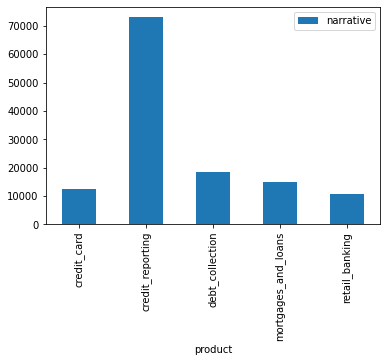

In [50]:
# Look at counts of complaints across categories for the train data set
train_data.groupby('product').count().plot(kind='bar')
plt.show()

Looking at the bar chart above, there are much more complaints that fall in the 'credit_reporting' category.  Again, I will use F1 score for the final model evaluation.

In [51]:
#Create a function to clean the text for each complaint
import nltk
from nltk.corpus import stopwords
from nltk import *

def clean_text2(main_df):
    df_1 = main_df.copy()

  # get rid of stopwords
    nltk.download('stopwords')      
    stop = stopwords.words('english')  
    df_1['narrative'] = df_1['narrative'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 
  
  # get rid of punctuations and convert to lower case
    df_1['narrative'] = df_1['narrative'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
  
  # get rid of double spaces
    df_1['narrative'] = df_1['narrative'].apply(lambda x: re.sub(' ', ' ', x))

    return df_1  

In [52]:
# Clean data for both the train and test data sets
train_data = clean_text2(train_data)
test_data = clean_text2(test_data)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
# Review if the data cleaning worked
train_data['narrative'].head()

155190    aka secured credit card account opened paid re...
157534    reported account report time two different col...
35967     booked trip take place paid deposit balance re...
83935     trying cosign mom vehicle car salesman told cr...
33508     writing citicards cbna difficulty applying new...
Name: narrative, dtype: object

In [54]:
# Create train labels
train_labels = train_data['product'] 
test_labels = test_data['product']
print(test_labels)

4605         credit_reporting
28723        credit_reporting
4398         credit_reporting
94639             credit_card
120194        debt_collection
                 ...         
23732     mortgages_and_loans
142970       credit_reporting
141819       credit_reporting
5935         credit_reporting
25184        credit_reporting
Name: product, Length: 32483, dtype: object


In [18]:
# Convert labels to numerical features
le = LabelEncoder()
le.fit(train_labels)
train_labels = le.transform(train_labels)
test_labels = le.transform(test_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

['credit_card' 'credit_reporting' 'debt_collection' 'mortgages_and_loans'
 'retail_banking']
(array([0, 1, 2, 3, 4]), array([12545, 72822, 18542, 15238, 10781]))
(array([0, 1, 2, 3, 4]), array([ 3021, 18350,  4606,  3752,  2754]))


In [41]:
# Change labels to categorical features (or 0s and 1s)
train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.array(test_labels))

In [20]:
# Define training parameters
max_sequence_length = 170 # setting the maximum length for all sequences   
max_words = 2500 # only 2500 most frequent words will be taken into account   

# Tokenize is breaking text into smaller pieces
tokenizer = Tokenizer(num_words = max_words)  # selects most frequently used words 
tokenizer.fit_on_texts(train_data.narrative)      # develops internal vocabulary based on training data set
train_sequences = tokenizer.texts_to_sequences(train_data.narrative)  # converts text to sequence of integers
test_sequences = tokenizer.texts_to_sequences(test_data.narrative) # converts text to sequence of integers

In [21]:
# Pad sequences is used to ensure that all sequences in a list have the same length
train_data = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen = max_sequence_length)
train_data.shape, test_data.shape

((129928, 170), (32483, 170))

## Deep Learning Model Architecture


In my model, I will use the following parameters:
- the batch size will be 48 because this is a power of 2 and will help my model run more efficiently. 
- softmax activation because this is a multiclass problem
- Bidirectional layer and then a MaxPool layer
- Dropout of 0.6 (50% to 80% is recommended)
- Adam optimizer. This optimizer combines the ideas from the AdaGrad and RMSProp optimizers

In [22]:
# Establishing the size of the real-valued vector space
embedding_dim = 32  

In [23]:
# Training the model.  Bidirectional LSTM effectively increases the amount of information available to the network.  
# This is often used in NLP.
model = Sequential()
model.add(Embedding(max_words, 
                   embedding_dim,
                   input_length=max_sequence_length))

model.add(Bidirectional(LSTM(16, return_sequences=True, dropout=0.6, recurrent_dropout=0)))

model.add(GlobalMaxPool1D()) #reduces the dimensionality of the feature maps output by the convolutional layer

model.add(Dense(5,activation='softmax'))

model.summary()

2022-12-05 19:19:25.847191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 19:19:25.848108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 19:19:26.040318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 19:19:26.041413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 19:19:26.042275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 170, 32)           80000     
_________________________________________________________________
bidirectional (Bidirectional (None, 170, 32)           6272      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 86,437
Trainable params: 86,437
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Specifying the loss, optimizer and metrics
model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics = ['accuracy'])  

In [25]:
# Train and validate the model 
history_model = model.fit(train_data, train_labels, batch_size=48, epochs= 20,
                    validation_data=(test_data, test_labels)) 

2022-12-05 19:19:30.439933: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-05 19:19:34.496675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2707/2707 [==============================] - 50s 16ms/step - loss: 0.2374 - accuracy: 0.7625 - val_loss: 0.1623 - val_accuracy: 0.8518
Epoch 2/20
2707/2707 [==============================] - 45s 16ms/step - loss: 0.1538 - accuracy: 0.8551 - val_loss: 0.1475 - val_accuracy: 0.8620
Epoch 3/20
2707/2707 [==============================] - 44s 16ms/step - loss: 0.1426 - accuracy: 0.8663 - val_loss: 0.1420 - val_accuracy: 0.8676
Epoch 4/20
2707/2707 [==============================] - 44s 16ms/step - loss: 0.1373 - accuracy: 0.8694 - val_loss: 0.1429 - val_accuracy: 0.8661
Epoch 5/20
2707/2707 [==============================] - 44s 16ms/step - loss: 0.1336 - accuracy: 0.8740 - val_loss: 0.1387 - val_accuracy: 0.8705
Epoch 6/20
2707/2707 [==============================] - 43s 16ms/step - loss: 0.1309 - accuracy: 0.8756 - val_loss: 0.1386 - val_accuracy: 0.8705
Epoch 7/20
2707/2707 [==============================] - 47s 17ms/step - loss: 0.1289 - accuracy: 0.8777 - val_loss: 0.1359 - val_accura

In [26]:
# Generate predictions
predicted_bd_lstm = model.predict(test_data)

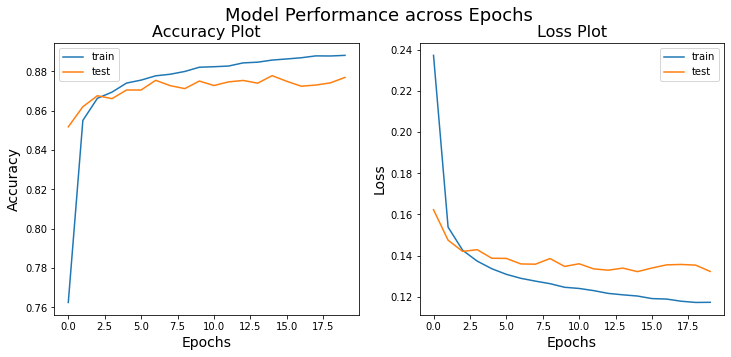

In [34]:
# Create a function to look at accuracy and loss across epochs
def accuracy_and_loss_plots(history):
    
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    fig.suptitle('Model Performance across Epochs', fontsize = 18)
    # Accuracy plot 
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Accuracy Plot', fontsize = 16)
    ax[0].set_xlabel('Epochs', fontsize = 14)
    ax[0].set_ylabel('Accuracy', fontsize = 14)
    ax[0].legend(['train', 'test'], loc='best')
    
    # Loss Plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Loss Plot', fontsize = 16)
    ax[1].set_xlabel('Epochs', fontsize = 14)
    ax[1].set_ylabel('Loss', fontsize = 14)
    ax[1].legend(['train', 'test'], loc='best')
    
    
accuracy_and_loss_plots(history_model)

For the train data set, the model showed substantial improvement going from 1 to 2 epochs for both accuracy and loss.  Afterwards, the improvement was small.  

For the test data set, there was small improvement from 1 to 2 epochs for both accuracy and loss.  Afterwards, the improvement was even smaller than in the train data set.

In [32]:
# Look at the confusion matrix and classification report after building and using the Deep Learning model
print("Confusion Matrix:\n\n",confusion_matrix(np.argmax(np.array(test_labels),axis=1), np.argmax(predicted_bd_lstm, axis=1)))
print("\n")
print("Classification Report:\n\n",classification_report(test_labels, predicted_bd_lstm.round()))

Confusion Matrix:

 [[ 2459   212    59    46   245]
 [  372 16755   782   361    80]
 [  142   625  3627   171    41]
 [  100   290   112  3168    82]
 [  158    44    28    48  2476]]


Classification Report:

               precision    recall  f1-score   support

           0       0.77      0.80      0.79      3021
           1       0.94      0.91      0.92     18350
           2       0.80      0.77      0.79      4606
           3       0.84      0.84      0.84      3752
           4       0.86      0.90      0.88      2754

   micro avg       0.88      0.87      0.88     32483
   macro avg       0.84      0.84      0.84     32483
weighted avg       0.88      0.87      0.88     32483
 samples avg       0.87      0.87      0.87     32483



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion

I was only able to improve the F1-scores slightly when using the deep learning model compared to the Random Forest model.  Below are the results from both models:

| Category            | Random Forest | Deep Learning |
|---------------------|---------------|---------------|
| Credit Card         | 0.74          | 0.79          |
| Credit Reporting    | 0.92          | 0.92          |
| Debt Collection     | 0.77          | 0.79          |
| Mortgages and Loans | 0.83          | 0.84          |
| Retail Banking      | 0.84          | 0.88          |

Also, the weighted average F1-score only improved slightly from 0.87 to 0.88.  My last 2 changes to the parameters in order to get this weighted average F1-score of 0.88 included:
- switched from RMSProp to Adam optimizer
- changed dropout from 0.4 to 0.6

I wanted to further improve on the parameters but I continued to get the message, 'IOPub message rate exceeded.'  But I think for the purpose of this class, I was able to build a sufficient deep learning model to accurately categorize consumer complaints.